## Imports:

In [1]:
import re
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchmetrics import BLEUScore
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Constants:

In [2]:
# Index values for start and end of sentence tokens
SOS_TOKEN = 0
EOS_TOKEN = 1

# Maximum length of sentence to create a one-hot vector
MAX_WORDS = 5

## Loading and Preparing Data:

In [3]:
# Language class
class Language:

  def __init__(self, name):
    self.name = name
    self.word_counts = {}
    self.word_to_index = {}
    self.index_to_word = {SOS_TOKEN: "SOS", EOS_TOKEN: "EOS"}
    self.n_words = 2; # Count of SOS and EOS

  # Method to add words in language
  def add_word(self, word):
    if word not in self.word_to_index:
      self.word_to_index[word] = self.n_words;
      self.index_to_word[self.n_words] = word;
      self.word_counts[word] = 1
      self.n_words += 1
    else:
      self.word_counts[word] += 1

  # Method to add sentence in language
  def add_sentence(self, sentence):
    for word in sentence.split(" "):
      self.add_word(word)

In [4]:
# Function to read sentences from file
def read_sentences_from_file(file_path):
  with open(file_path, encoding="utf-8") as in_file:
    lines = in_file.readlines()
    lines = [line.replace("\n", "") for line in lines]
  return lines

# Function to normalize sentence (Lowercase, trim, and remove non-letter characters)
def normalize_sentence(sentence):
  sentence = re.sub(r"([.!?])", r" \1", sentence)
  sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
  return sentence

In [5]:
# Function to read languages from files
def read_languages(language1_name, language2_name, reverse=False):
  
  # Reading sentences of both languages
  language1_sentences = read_sentences_from_file(language1_name + ".txt")
  language2_sentences = read_sentences_from_file(language2_name + ".txt")

  # Creating pairs of sentences
  sentence_pairs = []
  for i in range(len(language1_sentences)):
    sentence_pairs.append([normalize_sentence(language1_sentences[i]), language2_sentences[i]])

  # Creating language instances
  if not reverse:
    input_language = Language(language2_name)
    output_language = Language(language1_name)
  else:
    sentence_pairs = [list(reversed(sentence_pair)) for sentence_pair in sentence_pairs]
    input_language = Language(language1_name)
    output_language = Language(language2_name)

  return input_language, output_language, sentence_pairs

In [6]:
# Function to filter sentence pairs with maximim wordS defined
def filter_sentence_pairs(sentence_pairs):
  updated_sentence_pairs = []
  for sentence_pair in sentence_pairs:
    if len(sentence_pair[0].split(" ")) < MAX_WORDS and len(sentence_pair[1].split(" ")) < MAX_WORDS:
      updated_sentence_pairs.append(sentence_pair)
  return updated_sentence_pairs

In [7]:
# Function to prepare data for input to model
def prepare_data(language1_name, language2_name, reverse=False):
  
  # Reading languages
  input_language, output_language, sentence_pairs = read_languages(language1_name, language2_name, reverse)
  print("Total sentence pairs:", len(sentence_pairs))
  
  # Filtering sentence pairs
  sentence_pairs = filter_sentence_pairs(sentence_pairs)
  print("Filtered sentence pairs:", len(sentence_pairs))

  # Adding sentences in languages
  for sentence_pair in sentence_pairs:
    input_language.add_sentence(sentence_pair[0])
    output_language.add_sentence(sentence_pair[1])
  print("Total words (", input_language.name, "): ", input_language.n_words, sep="")
  print("Total words (", output_language.name, "): ", output_language.n_words, sep="")

  return input_language, output_language, sentence_pairs

In [8]:
# Function to create a tensor from sentence
def get_tensor_from_sentence(language, sentence):
  indices = [language.word_to_index[word] for word in sentence.split(" ")]
  indices.append(EOS_TOKEN)
  return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

# Function to create tensors from sentence pairs
def get_tensors_from_sentence_pair(input_language, output_language, sentence_pair):
  input_tensor = get_tensor_from_sentence(input_language, sentence_pair[0])
  target_tensor = get_tensor_from_sentence(output_language, sentence_pair[1])
  return input_tensor, target_tensor

In [9]:
# Loading languages data
input_language, output_language, sentence_pairs = prepare_data("English", "Urdu", True)
random.choice(sentence_pairs)

Total sentence pairs: 100000
Filtered sentence pairs: 4322
Total words (English): 4057
Total words (Urdu): 3832


['ہماری؟', ' We ?']

## Splitting data (Train and Test):

In [10]:
# Splitting data into train and test
train_sentence_pairs, test_sentence_pairs = train_test_split(sentence_pairs, test_size=0.15)
len(train_sentence_pairs), len(test_sentence_pairs)

(3673, 649)

## The Encoder:

In [11]:
# Encoder (RNN) class
class EncoderRNN(nn.Module):

  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder:

In [12]:
# Attention decoder (RNN) class
class AttentionDecoderRNN(nn.Module):
  
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_WORDS):
    super(AttentionDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.attention = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = self.dropout(embedded)
    attention_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    attention_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
    output = torch.cat((embedded[0], attention_applied[0]), 1)
    output = self.attention_combine(output).unsqueeze(0)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attention_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

## Sequence to Sequence Model:

In [13]:
# Function to train sequence to sequence neural network model
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_WORDS, teacher_forcing_ratio=0.5):
  encoder_hidden = encoder.initHidden()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)  
  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
  loss = 0

  # Encoder feed forward mechanism
  for i in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
    encoder_outputs[i] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
  decoder_hidden = encoder_hidden
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  # Decoder feed forward mechanism
  if use_teacher_forcing: # Teacher forcing: Feed the target as the next input
    for i in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[i])
      decoder_input = target_tensor[i]  # Teacher forcing
  else:
    for i in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # detach from history as input
      loss += criterion(decoder_output, target_tensor[i])
      if decoder_input.item() == EOS_TOKEN:
        break

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item()

In [14]:
# Function to evaluate sequence to sequence neural network model
def evaluate(encoder, decoder, sentence, max_length=MAX_WORDS):
  with torch.no_grad():
    input_tensor = get_tensor_from_sentence(input_language, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Encoder feed forward mechanism
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i],encoder_hidden)
        encoder_outputs[i] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
    decoder_hidden = encoder_hidden
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    # Decoder feed forward mechanism
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        if topi.item() == EOS_TOKEN:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_language.index_to_word[topi.item()])
        decoder_input = topi.squeeze().detach()

    return decoded_words, decoder_attentions[:di + 1]

## Model Training:

In [15]:
# Function to start model training
def start_training(encoder, decoder, n_iterations, train_tensors, learning_rate=0.01):

  # Setting optimizers
  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
  
  # Setting loss criteria
  criterion = nn.NLLLoss()

  # Initializing losses list (Of all iterations)
  losses = []
  total_loss = 0

  for i in tqdm(range(n_iterations)):
    train_tensor = train_tensors[i % len(train_tensors)]
    input_tensor = train_tensor[0]
    target_tensor = train_tensor[1]
    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    total_loss += loss

    # After whole batch is processed
    if i % len(train_tensors) == 0 and i != 0: # Exclude first iteration
      average_loss = total_loss / len(train_tensors)
      losses.append(average_loss)
      total_loss = 0
  return losses

In [16]:
# Initializing hyperparameters
n_iterations = 100000
hidden_size = 256
train_tensors = [get_tensors_from_sentence_pair(input_language, output_language, train_sentence_pair) for train_sentence_pair in train_sentence_pairs]
encoderRNN = EncoderRNN(input_language.n_words, hidden_size).to(device)
decoderRNN = AttentionDecoderRNN(hidden_size, output_language.n_words).to(device)

In [17]:
# Starting model training
losses = start_training(encoderRNN, decoderRNN, n_iterations, train_tensors)

100%|██████████| 100000/100000 [1:23:07<00:00, 20.05it/s]


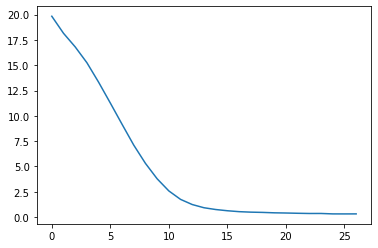

In [18]:
# Plotting losses of iterations
sns.lineplot(data=losses)
plt.show()

## Model Evaluation:

In [19]:
# Method to evaluate model on test data
def start_evaluation(encoder, decoder, test_sentence_pairs, n=5):
  actual_translations = []
  predicted_translations = []
  for i in range(n):
    test_sentence_pair = random.choice(test_sentence_pairs)
    print("Sentence:", test_sentence_pair[0])
    print("Actual translation:", test_sentence_pair[1])
    output_translated_words, attentions = evaluate(encoder, decoder, test_sentence_pair[0])
    output_translation = ' '.join(output_translated_words)
    print("Predicted translation:", output_translation)
    print()
    actual_translations.append(test_sentence_pair[1])
    predicted_translations.append(output_translation)
  return actual_translations, predicted_translations

In [20]:
# Starting model evaluation on test set
actual_translations, predicted_translations = start_evaluation(encoderRNN, decoderRNN, train_sentence_pairs, 10)

Sentence: میں مل گیا۔
Actual translation: He found me .
Predicted translation: He found me . <EOS>

Sentence: جھگڑنا ۔
Actual translation: Pull caps .
Predicted translation: Pull caps . <EOS>

Sentence: یہ میرا ہے:
Actual translation: Here is mine 
Predicted translation: Here is mine  <EOS>

Sentence: کنجوس شخص
Actual translation: A close fisted man
Predicted translation: A close fisted man <EOS>

Sentence: خمیازہ بھگتنا
Actual translation: Face the music
Predicted translation: Face the music <EOS>

Sentence: امیر ۔
Actual translation: Well off .
Predicted translation: Well off . <EOS>

Sentence: علامہ محمد یوسف ۔
Actual translation: Allama Muhammad Yusuf .
Predicted translation: Allama Muhammad Yusuf . <EOS>

Sentence: نیا حاصل شدہ ۔
Actual translation: New fangled .
Predicted translation: New fangled . <EOS>

Sentence: حقوق کے بل
Actual translation: Bill of Rights
Predicted translation: Bill of Rights <EOS>

Sentence: ٹیکسٹنگ سافٹ ویئر
Actual translation: Texting Software
Predicted t

In [21]:
# Bleu score of actual and predicted translations (Train set)
metric = BLEUScore(n_gram=1)
references = [[actual_translation] for actual_translation in actual_translations]
metric(predicted_translations, references)

tensor(0.7619)

In [22]:
# Starting model evaluation on test set
actual_translations, predicted_translations = start_evaluation(encoderRNN, decoderRNN, test_sentence_pairs, 10)

Sentence: نشان.barabak @ latimes.com
Actual translation: mark .barabak latimes .com
Predicted translation:  Report Khan  <EOS>

Sentence: لات ، Godzilla.
Actual translation: DAMN GODZILLA .
Predicted translation: To look with . <EOS>

Sentence: ادلے کا بدلہ
Actual translation: tit for tat
Predicted translation: Tit for tat <EOS>

Sentence: بہت زیادہ ۔
Actual translation: A fat lot .
Predicted translation: No end . <EOS>

Sentence: msnbc.com ویڈیو پلیئر
Actual translation: msnbc .com Video Player
Predicted translation: KM Player <EOS>

Sentence: بیکار آدمی  ۔
Actual translation: Rotten egg .
Predicted translation: Rotten egg . <EOS>

Sentence: بڑی شخصیت	
Actual translation: Big gun
Predicted translation: Big gun <EOS>

Sentence: (istockphoto)
Actual translation:  istockphoto 
Predicted translation: The <EOS>

Sentence: چھوٹی سی بات
Actual translation: Little thing
Predicted translation: Small will great <EOS>

Sentence: موجود
Actual translation: Possessed ?
Predicted translation: Not . 

In [23]:
# Bleu score of actual and predicted translations (Test set)
metric = BLEUScore(n_gram=1)
references = [[actual_translation] for actual_translation in actual_translations]
metric(predicted_translations, references)

tensor(0.2857)